In [1]:
pip install torch torchvision torch-geometric sentence-transformers pandas scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.2 MB/s eta 0:00:00


Loaded dataset with 20577 entries.
Encoding text using SentenceTransformer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Epoch 1/20, Loss: 1.0998
Epoch 2/20, Loss: 1.0804
Epoch 3/20, Loss: 1.0640
Epoch 4/20, Loss: 1.0458
Epoch 5/20, Loss: 1.0308
Epoch 6/20, Loss: 1.0225
Epoch 7/20, Loss: 1.0151
Epoch 8/20, Loss: 1.0120
Epoch 9/20, Loss: 1.0037
Epoch 10/20, Loss: 1.0040
Epoch 11/20, Loss: 0.9988
Epoch 12/20, Loss: 0.9968
Epoch 13/20, Loss: 0.9955
Epoch 14/20, Loss: 0.9919
Epoch 15/20, Loss: 0.9917
Epoch 16/20, Loss: 0.9885
Epoch 17/20, Loss: 0.9860
Epoch 18/20, Loss: 0.9863
Epoch 19/20, Loss: 0.9860
Epoch 20/20, Loss: 0.9845
Training complete.

Classification Report:
                    precision    recall  f1-score   support

      Not Relevant       0.86      0.43      0.58     15191
Partially Relevant       0.20      0.52      0.29      2537
          Relevant       0.26      0.57      0.36      2849

          accuracy                           0.46     20577
         macro avg       0.44      0.51      0.41     20577
      weighted avg       0.70      0.46      0.51     20577



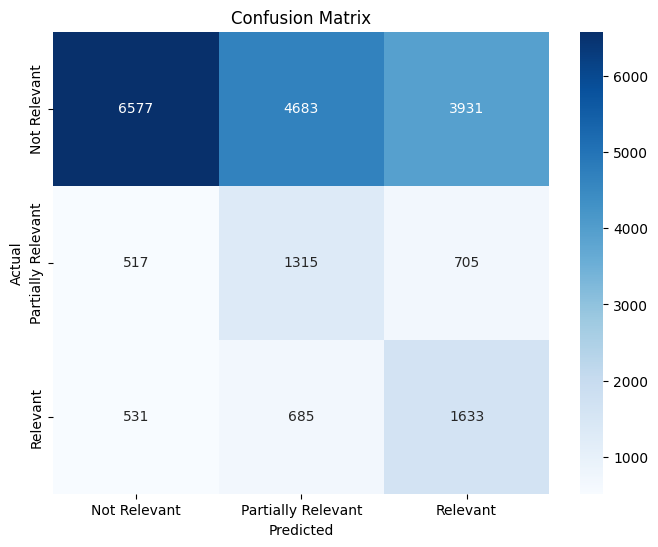

In [2]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sentence_transformers import SentenceTransformer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import WeightedRandomSampler
import numpy as np

# --- Step 1: Load and Preprocess Dataset ---
def load_and_preprocess_dataset(file_path):
    df = pd.read_csv(file_path, delimiter=',')
    print(f"Loaded dataset with {len(df)} entries.")

    queries = df['query'].astype(str)
    abstracts = df['abstract'].astype(str)
    labels = df['judgement'].astype(int)

    print("Encoding text using SentenceTransformer...")
    model = SentenceTransformer('all-MiniLM-L6-v2')
    query_embeddings = torch.tensor(model.encode(queries), dtype=torch.float)
    abstract_embeddings = torch.tensor(model.encode(abstracts), dtype=torch.float)

    return query_embeddings, abstract_embeddings, torch.tensor(labels, dtype=torch.long)

dataset_path = "/content/cleaned_merged_data.csv"
query_embeddings, abstract_embeddings, labels = load_and_preprocess_dataset(dataset_path)

# --- Step 2: Create Graph Structure ---
def create_graph(query_embeddings, abstract_embeddings, labels):
    num_queries = len(query_embeddings)
    num_abstracts = len(abstract_embeddings)

    # Compute cosine similarity between queries and abstracts
    similarity_matrix = torch.mm(query_embeddings, abstract_embeddings.T)

    # Connect each query to top-k related abstracts
    k = 5
    adj_matrix = torch.zeros((num_queries + num_abstracts, num_queries + num_abstracts))
    for i in range(num_queries):
        top_k_indices = torch.topk(similarity_matrix[i], k=k).indices + num_queries
        adj_matrix[i, top_k_indices] = 1

    # Convert to sparse format
    edge_index, _ = dense_to_sparse(adj_matrix)

    # Combine node features
    node_features = torch.cat([query_embeddings, abstract_embeddings], dim=0)

    # Graph data
    data = Data(x=node_features, edge_index=edge_index, y=labels)
    return data, num_queries

data, num_queries = create_graph(query_embeddings, abstract_embeddings, labels)

# --- Step 3: Define GCN Model ---
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)  # Output layer for classification
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)

        # Second GCN layer (classification output)
        x = self.conv2(x, edge_index)
        return x

# --- Step 4: Train the Model ---
def train_model(model, data, num_queries, epochs=20, lr=0.01):
    # Calculate class weights
    class_counts = torch.bincount(data.y)
    class_weights = len(data.y) / (len(class_counts) * class_counts.float())
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)[:num_queries]  # Only for query nodes
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    print("Training complete.")

# --- Step 5: Evaluate the Model ---
def evaluate_model(model, data, num_queries):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)[:num_queries]
        predictions = torch.argmax(out, dim=1)
        print("\nClassification Report:")
        print(classification_report(data.y.numpy(), predictions.numpy(), target_names=["Not Relevant", "Partially Relevant", "Relevant"]))

        # Generate confusion matrix
        conf_matrix = confusion_matrix(data.y.numpy(), predictions.numpy())
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
                    xticklabels=["Not Relevant", "Partially Relevant", "Relevant"],
                    yticklabels=["Not Relevant", "Partially Relevant", "Relevant"])
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

# --- Step 6: Run Training and Evaluation ---
input_dim = query_embeddings.size(1)
hidden_dim = 128
output_dim = 3  # Three classes: Not Relevant, Partially Relevant, Relevant

model = GCN(input_dim, hidden_dim, output_dim)
train_model(model, data, num_queries, epochs=20, lr=0.01)
evaluate_model(model, data, num_queries)


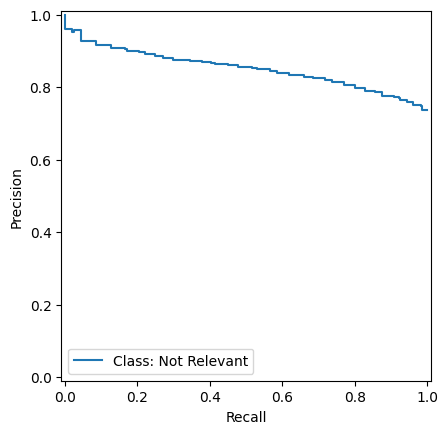

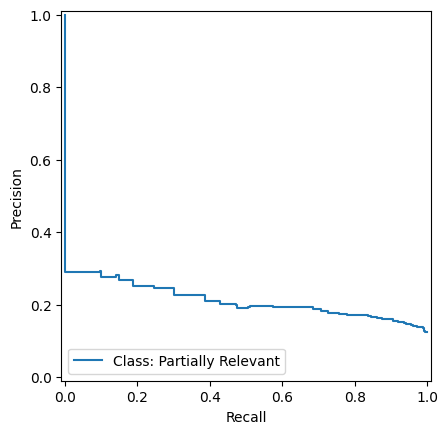

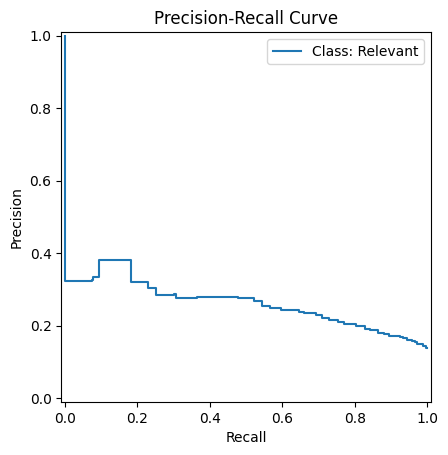

In [3]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Function to plot Precision-Recall Curve
def plot_precision_recall_curve(model, data, num_queries):
    model.eval()
    with torch.no_grad():
        # Get predictions and probabilities
        out = model(data.x, data.edge_index)[:num_queries]
        probabilities = torch.softmax(out, dim=1).numpy()
        true_labels = data.y.numpy()

        # For each class, calculate Precision-Recall curve
        for i, class_name in enumerate(["Not Relevant", "Partially Relevant", "Relevant"]):
            precision, recall, _ = precision_recall_curve(true_labels == i, probabilities[:, i])
            display = PrecisionRecallDisplay(precision=precision, recall=recall)
            display.plot(label=f"Class: {class_name}")

    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()

# Call the function
plot_precision_recall_curve(model, data, num_queries)


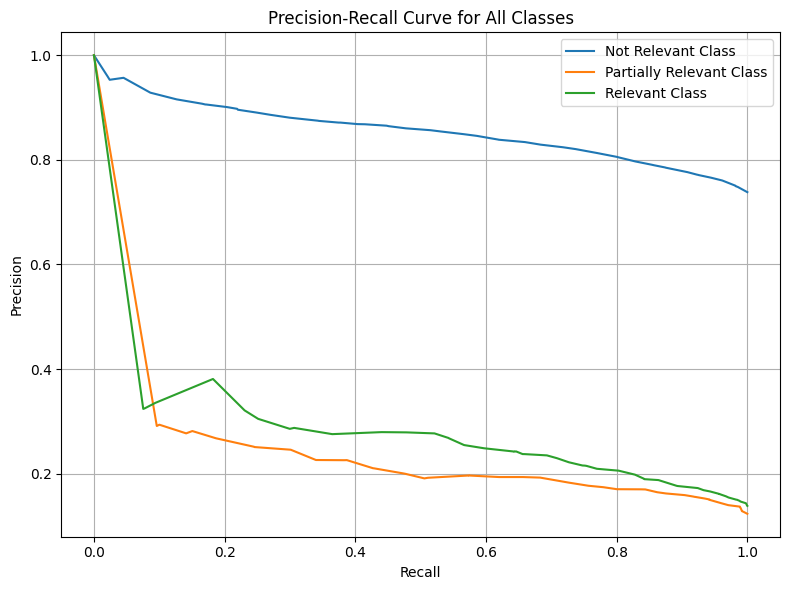

In [4]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Function to plot all Precision-Recall Curves in one figure
def plot_combined_precision_recall_curve(model, data, num_queries):
    model.eval()
    with torch.no_grad():
        # Get predictions and probabilities
        out = model(data.x, data.edge_index)[:num_queries]
        probabilities = torch.softmax(out, dim=1).numpy()
        true_labels = data.y.numpy()

        # Initialize the plot
        plt.figure(figsize=(8, 6))

        # For each class, calculate and plot Precision-Recall curve
        for i, class_name in enumerate(["Not Relevant", "Partially Relevant", "Relevant"]):
            precision, recall, _ = precision_recall_curve(true_labels == i, probabilities[:, i])
            plt.plot(recall, precision, label=f"{class_name} Class")

        # Set plot labels and legend
        plt.title("Precision-Recall Curve for All Classes")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend(loc="best")
        plt.grid()
        plt.tight_layout()
        plt.show()

# Call the function
plot_combined_precision_recall_curve(model, data, num_queries)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import torch

# Mount Google Drive (only if using Colab)
from google.colab import drive
drive.mount('/content/drive')

# Path where the file will be saved in Google Drive
google_drive_path = "/content/drive/MyDrive/subset_query_document_results.csv"

df = pd.read_csv(dataset_path, delimiter=',')

def evaluate_and_save_subset(
    model,
    data,
    num_queries,
    query_texts,
    document_texts,
    labels,
    num_docs_per_query=5,
    file_path="subset_results.csv"
):
    model.eval()
    with torch.no_grad():
        # Get predictions for all query nodes
        out = model(data.x, data.edge_index)[:num_queries]
        predictions = torch.argmax(out, dim=1)

        # Collect data for all queries
        query_results = []
        for query_idx in range(num_queries):
            # Find documents connected to this query
            connected_docs = data.edge_index[1, data.edge_index[0] == query_idx].unique()

            # Select up to num_docs_per_query documents
            selected_docs = connected_docs[:num_docs_per_query] if len(connected_docs) >= num_docs_per_query else connected_docs

            for doc_idx in selected_docs:
                query_results.append({
                    "Query": query_texts[query_idx],  # Use original query text
                    "Document": document_texts[doc_idx - num_queries],  # Use original document text
                    "Actual": labels[query_idx].item(),
                    "Predicted": predictions[query_idx].item()
                })

        # Save to Google Drive (or your desired location)
        results_df = pd.DataFrame(query_results)
        results_df.to_csv(google_drive_path, index=False)
        print(f"Subset results saved to {google_drive_path}")

evaluate_and_save_subset(
    model,
    data,
    num_queries,
    query_texts=df['query'].tolist(),  # Original query text from the DataFrame
    document_texts=df['abstract'].tolist(),  # Original document text from the DataFrame
    labels=labels,
    num_docs_per_query=5,
    file_path="subset_query_document_results.csv"
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Subset results saved to /content/drive/MyDrive/subset_query_document_results.csv
